In [69]:
import pandas as pd 
import altair as alt
import datetime

pd.options.display.max_rows = 100
from bs4 import BeautifulSoup
import requests
import re

url = 'https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/covid-19-daily-deaths'
r = requests.get(url)
soup = BeautifulSoup(r.text)

a = soup.findAll('a', href=re.compile("total-announced-deaths-"))

for link in a:
    f1 = "weekly" in link.text
    f2 = "weekly" in link.attrs["href"]
    if not (f1 or f2):
        href = link.attrs["href"]
        text = link.text
        
filename = href.split("/")[-1].replace(".xlsx", "").replace(".xls", "").lower()

df = pd.read_excel(href, sheet_name="Tab4 Deaths by trust", skiprows=15, usecols="B:EA")


cols = list(df.columns)
cols = [c for c in cols if "Unnamed:" not in str(c)]
df = df[cols]

df = df.loc[:, "NHS England Region":"Total"]
df = df.iloc[2:, :]

dt_cols = [c for c in cols if type(c) == datetime.datetime]
other_cols = [c for c in cols if type(c) != datetime.datetime]

df = df.melt(id_vars = other_cols, value_vars=dt_cols)

df = df.rename(columns={"variable": "date", "value": 'num_deaths'})


df = df.sort_values(["Name", "date"])
df["sum_deaths_rolling_week"] = df.groupby('Name')['num_deaths'].rolling(7).sum().reset_index(0,drop=True)


f1 = df["Name"].str.lower().str.contains("oxford university")
f2 = df["Name"].str.lower().str.contains("west hertfordshire")
f3 = df["Name"].str.lower().str.contains("cambridge university")

df.loc[f1|f2|f3, "highlight"] = "yes"
df.loc[~(f1|f2|f3), "highlight"] = "no"

df2 = df[f1|f2|f3]

alt.data_transformers.enable('json')
c1 = alt.Chart(df).mark_line().encode(
    x='date',
    y='sum_deaths_rolling_week',
    color=alt.Color('Name',  scale=None),
    tooltip=['Name', "date", "sum_deaths_rolling_week"]
)

c2 = alt.Chart(df2).mark_line().encode(
    x='date',
    y='sum_deaths_rolling_week',
    color='Name',
    tooltip=['Name', "date", "sum_deaths_rolling_week"]
)

c3 = (c1 + c2).properties(height=500, width=800)



# with alt.data_transformers.enable('default'):
#     c3.save('chart.png')

# df = df.drop("highlight", axis=1)
# df.to_csv("clean_nhs_data_latest.csv", index=False, encoding='utf-8')
# df.to_parquet("clean_nhs_data_latest.parquet", index=False)


# fn = filename.replace("covid-19-total-announced-deaths-", "")

# df.to_csv(f"clean_nhs_data_{fn}.csv", index=False, encoding='utf-8')
# df.to_parquet(f"clean_nhs_data_{fn}.parquet", index=False)

df = df.sort_values(["Name", "date"])
df["diff_sum_deaths_rolling_week"]  = df.groupby('Name')['sum_deaths_rolling_week'].diff(7)


In [70]:
# Charts for:
## 5 biggest abs rises
## 4 biggest asb fallers
## By region


In [77]:

f1 = df.date == df.date.max()
most_deaths = list(df[f1].sort_values("sum_deaths_rolling_week", ascending=False).head(5)["Name"])
most_deaths

['PENNINE ACUTE HOSPITALS NHS TRUST',
 'NORTH WEST ANGLIA NHS FOUNDATION TRUST',
 'EAST KENT HOSPITALS UNIVERSITY NHS FOUNDATION TRUST',
 'MANCHESTER UNIVERSITY NHS FOUNDATION TRUST',
 'NORTHAMPTON GENERAL HOSPITAL NHS TRUST']

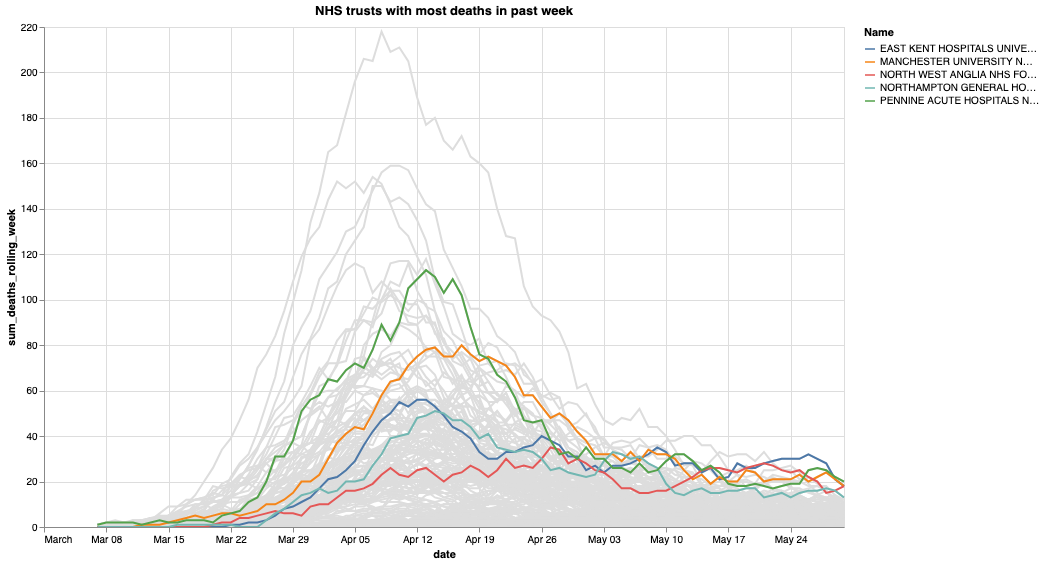

In [84]:
alt.data_transformers.enable('json')
f1 = df["Name"].isin(most_deaths)
df2 = df[f1]
c1 = alt.Chart(df).mark_line().encode(
    x='date',
    y='sum_deaths_rolling_week',
    color=alt.Color('Name',  scale=None),
    tooltip=['Name', "date", "sum_deaths_rolling_week"]
)

c2 = alt.Chart(df2).mark_line().encode(
    x='date',
    y='sum_deaths_rolling_week',
    color='Name',
    tooltip=['Name', "date", "sum_deaths_rolling_week"]
)

c3 = (c1 + c2).properties(height=500, width=800, title="NHS trusts with most deaths in past week")
c3


In [94]:
f1 = df.date == df.date.max()
greatest_increase = list(df[f1].sort_values("diff_sum_deaths_rolling_week", ascending=False).head(5)["Name"])
greatest_increase

['TAMESIDE AND GLOSSOP INTEGRATED CARE NHS FOUNDATION TRUST',
 'BARNSLEY HOSPITAL NHS FOUNDATION TRUST',
 'CALDERDALE AND HUDDERSFIELD NHS FOUNDATION TRUST',
 'NORTHERN LINCOLNSHIRE AND GOOLE NHS FOUNDATION TRUST',
 'LONDON NORTH WEST UNIVERSITY HEALTHCARE NHS TRUST']

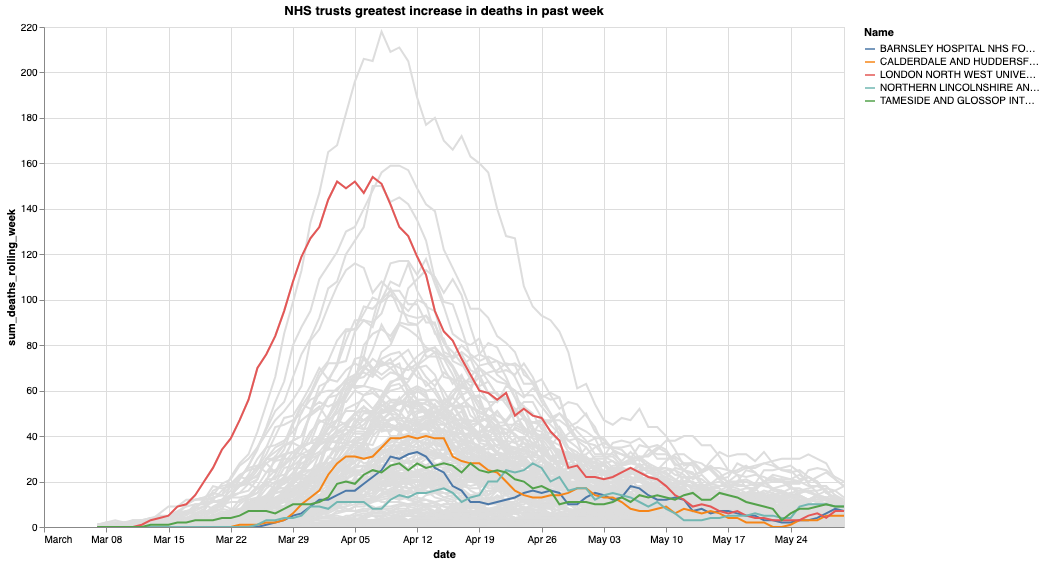

In [95]:
alt.data_transformers.enable('json')
f1 = df["Name"].isin(greatest_increase)
df2 = df[f1]
c1 = alt.Chart(df).mark_line().encode(
    x='date',
    y='sum_deaths_rolling_week',
    color=alt.Color('Name',  scale=None),
    tooltip=['Name', "date", "sum_deaths_rolling_week"]
)

c2 = alt.Chart(df2).mark_line().encode(
    x='date',
    y='sum_deaths_rolling_week',
    color='Name',
    tooltip=['Name', "date", "sum_deaths_rolling_week"]
)

c3 = (c1 + c2).properties(height=500, width=800, title="NHS trusts greatest increase in deaths in past week")
c3


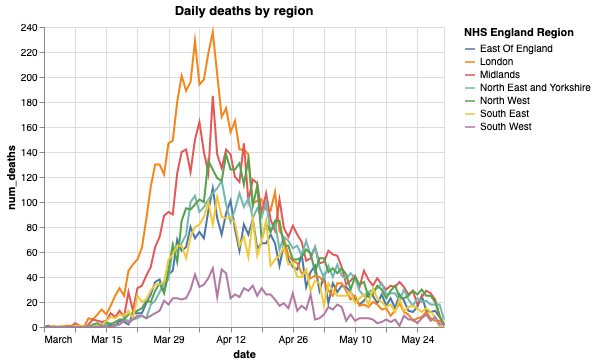

In [104]:
regions = df.groupby(["NHS England Region", "date"]).sum().reset_index()
c1 = alt.Chart(regions).mark_line().encode(
    x='date',
    y='num_deaths',
    color=alt.Color('NHS England Region'),
    tooltip=['NHS England Region', "date", "num_deaths"]
).properties(title="Daily deaths by region")
c1